In [1]:
import numpy as np
import pandas as pd
from scipy import interpolate

import xarray as xr
import dask.array as da
from dask.distributed import Client

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches # for creating legend
import matplotlib.dates as mdates # converts datetime64 to datetime

import cartopy
import cartopy.crs as ccrs # for plotting
import cartopy.feature as cfeature # for map features
from cartopy.util import add_cyclic_point # for wrapping map fully - avoiding white line on 0 deg
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

import matplotlib.dates as mdates # converts datetime64 to datetime
import matplotlib.gridspec as gridspec # to create grid-shaped combos of axes
from mpl_toolkits import mplot3d # 3d plotting tool
import cmocean # for nice oceanography colour pallettes

#import argopy
#from argopy import DataFetcher as ArgoDataFetcher # to load Argo ds directly

import os # for finding files

import gsw # for conversion functions

from tqdm.notebook import tqdm_notebook as tqdm
import glob # for downloading data
import sys # for path to functions

import seaborn as sns

sns.set(#font='Helvetica',
        rc={
         'axes.axisbelow': False,
         'axes.edgecolor': 'Black',
         'axes.facecolor': 'w', 
                            # '#aeaeae',
         'axes.grid': False,
         'axes.labelcolor': 'k',
         'axes.spines.right': True,
         'axes.spines.top': True,
         'figure.facecolor': 'white',
         'lines.solid_capstyle': 'round',
         'patch.edgecolor': 'k',
         'patch.force_edgecolor': True,
         'text.color': 'k',
         'xtick.bottom': True,
         'xtick.color': 'k',
         'xtick.direction': 'out',
         'xtick.top': False,
         'ytick.color': 'k',
         'ytick.direction': 'out',
         'ytick.left': True,
         'ytick.right': False},
         font_scale=1)
mpl.rcParams["figure.titlesize"] = 25
mpl.rcParams["axes.titlesize"] = 22
mpl.rcParams["axes.labelsize"] = 20
mpl.rcParams["font.size"] = 18
mpl.rcParams["xtick.labelsize"] = 18
mpl.rcParams["ytick.labelsize"] = 18
mpl.rcParams["ytick.labelright"] = False

from warnings import filterwarnings as fw
fw('ignore')

# import my own funcs
import sys
sys.path.append('/home/theospira/notebooks/projects/01-WW_climatology/functions')
from plot_formatting import circular_boundary,plot_nice_box
from inspection_funcs import boxplot

import importlib
#importlib.reload(sys.modules['inspection_plot'])

In [2]:
from matplotlib.dates import AutoDateLocator

sys.path.append('/home/theospira/notebooks/projects/03-WW-timeseries/funcs')
from plotting import *
from computations import *
from import_data import *

# load data

In [3]:
from gridding import vincents_median_grid_var,median_gridding_ts

In [4]:
def print_ranges(ww_ss):
    for v in ['thcc','up_bd','lw_bd']:
        print(v, ww_ss[v].mean(('lat','lon')).min().data, ww_ss[v].mean(('lat','lon')).max().data, ww_ss[v].mean(('lat','lon')).max().data-ww_ss[v].mean(('lat','lon')).min().data)

In [5]:
d_path='/home/theospira/notebooks/projects/03-WW-timeseries/data/hydrographic_profiles/'
ds = xr.open_dataset(d_path+'hydrographic_profiles_1.nc')

## WW_SS thinning

In [8]:
# grid WW_ML data
tmp = ds.isel(n_prof=np.where((ds.ww_type==1))[0])

arr = []
for v in tqdm(['up_bd_z','lw_bd_z','thcc_z']):
    arr += median_gridding_ts(tmp[v]),

#ww_ml = xr.merge(ds_grid)

x    = 1 
time = pd.date_range('2004-01-01', '2022-01-01', freq='1M')
lat  = np.arange(-79.5,-40.5+x,x)
lon  = np.arange(-180,180,x) + x/2

ww_ml = xr.Dataset(
            data_vars = dict(up_bd = (['time','lon','lat',], arr[0].data),
                             lw_bd = (['time','lon','lat',], arr[1].data),
                             thcc  = (['time','lon','lat',], arr[2].data),
                            ),
            coords   = dict(time    = (['time'], time),
                            lon     = (['lon'], lon),
                            lat     = (['lat'], lat),
                            ),)
for v in ['up_bd', 'lw_bd', 'thcc']:
    ww_ml[v].attrs['units'] = 'm'

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/216 [00:00<?, ?it/s]

  0%|          | 0/216 [00:00<?, ?it/s]

  0%|          | 0/216 [00:00<?, ?it/s]

AttributeError: 'DataArray' object has no attribute 'attributes'

In [18]:
# grid WW_SS data
tmp = ds.isel(n_prof=np.where((ds.ww_type==2))[0])

arr = []
for v in tqdm(['up_bd_z','lw_bd_z','thcc_z']):
    arr += median_gridding_ts(tmp[v]),

x    = 1 
time = pd.date_range('2004-01-01', '2022-01-01', freq='1M')
lat  = np.arange(-79.5,-40.5+x,x)
lon  = np.arange(-180,180,x) + x/2

ww_ss = xr.Dataset(
            data_vars = dict(up_bd = (['time','lon','lat',], arr[0].data),
                             lw_bd = (['time','lon','lat',], arr[1].data),
                             thcc  = (['time','lon','lat',], arr[2].data),
                            ),
            coords   = dict(time    = (['time'], time),
                            lon     = (['lon'], lon),
                            lat     = (['lat'], lat),
                            ),)

for v in ['up_bd', 'lw_bd', 'thcc']:
    ww_ss[v].attrs['units'] = 'm'

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/216 [00:00<?, ?it/s]

  0%|          | 0/216 [00:00<?, ?it/s]

  0%|          | 0/216 [00:00<?, ?it/s]

In [19]:
# add ww_ct for masking
ww_ml['ww_ct'] = xr.DataArray(xr.open_dataset(d_path+'gridded-timeseries-ww-recalc1.nc')['ww_ct'].data,
                              dims=['time','lon','lat'])
ww_ss['ww_ct'] = xr.DataArray(xr.open_dataset(d_path+'gridded-timeseries-ww-recalc1.nc')['ww_ct'].data,
                              dims=['time','lon','lat'])

for v in ['up_bd', 'lw_bd', 'thcc']:
    ww_ml = calc_mean_var(ww_ml,v)
    ww_ml[v+'_anm'] = ww_ml[v] - ww_ml[v+'_mn']


for v in ['up_bd', 'lw_bd', 'thcc']:
    ww_ss = calc_mean_var(ww_ss,v)
    ww_ss[v+'_anm'] = ww_ss[v] - ww_ss[v+'_mn']

# mask thickness data
msk_ml = mask_data(ww_ml)
msk_ss = mask_data(ww_ss)

contains ww_ct
contains ww_ct


In [20]:
# compute temperature gradient across upper and lower boundaries

tmp = ds.isel(n_prof=np.where((ds.ww_type==2))[0])[['ctemp']]#,'R']]
tmp = tmp.where(ds.pres==ds.lw_bd+4).sum('pres') - tmp.where(ds.pres==ds.lw_bd-4).sum('pres')
tmp = tmp.where(tmp!=0,)

# grid variable
arr = []
for v in tqdm(['ctemp']):
    arr += median_gridding_ts(tmp[v]),

x    = 1 
time = pd.date_range('2004-01-01', '2022-01-01', freq='1M')
lat  = np.arange(-79.5,-40.5+x,x)
lon  = np.arange(-180,180,x) + x/2

deltaT = xr.Dataset(
            data_vars = dict(ctemp = (['time','lon','lat',], arr[0]),
                            ),
            coords   = dict(time   = (['time'], time),
                            lon    = (['lon'], lon),
                            lat    = (['lat'], lat),
                            ),)

# mask data
deltaT['ww_ct'] = xr.DataArray(xr.open_dataset(d_path+'gridded-timeseries-ww-recalc1.nc')['ww_ct'].data,
                               dims=['time','lon','lat'])
deltaT = mask_data(deltaT)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/216 [00:00<?, ?it/s]

contains ww_ct


In [21]:
# load sea ice
si = load_sea_ice()
si = si.sel(lat=slice(-80,-52)).sel(time=slice('2005-01-01','2022-01-01'))
# mask sea ice data
#si['ww_ct'] = tmp['ww_ct'].copy()
#si = mask_data(si)
si = calc_mean_var(si,'sia')
si = calc_mean_var(si,'sic')

# compute sia_anm
si['sia_anm'] = si.sia - si.sia_mn

cmap_br = get_cmap()

slope 1:  -0.15351309224766743  per unit time
slope 2:  0.001468270318481517  per unit time
slope 1:  -0.018072917339891793  per unit time
slope 2:  -0.021797908556754956  per unit time
slope 1:  -0.17172297366752182  per unit time
slope 2:  -0.02638306863518694  per unit time
slope 1:  0.0007849332672378358  per unit time
slope 2:  8.865300953095165e-05  per unit time


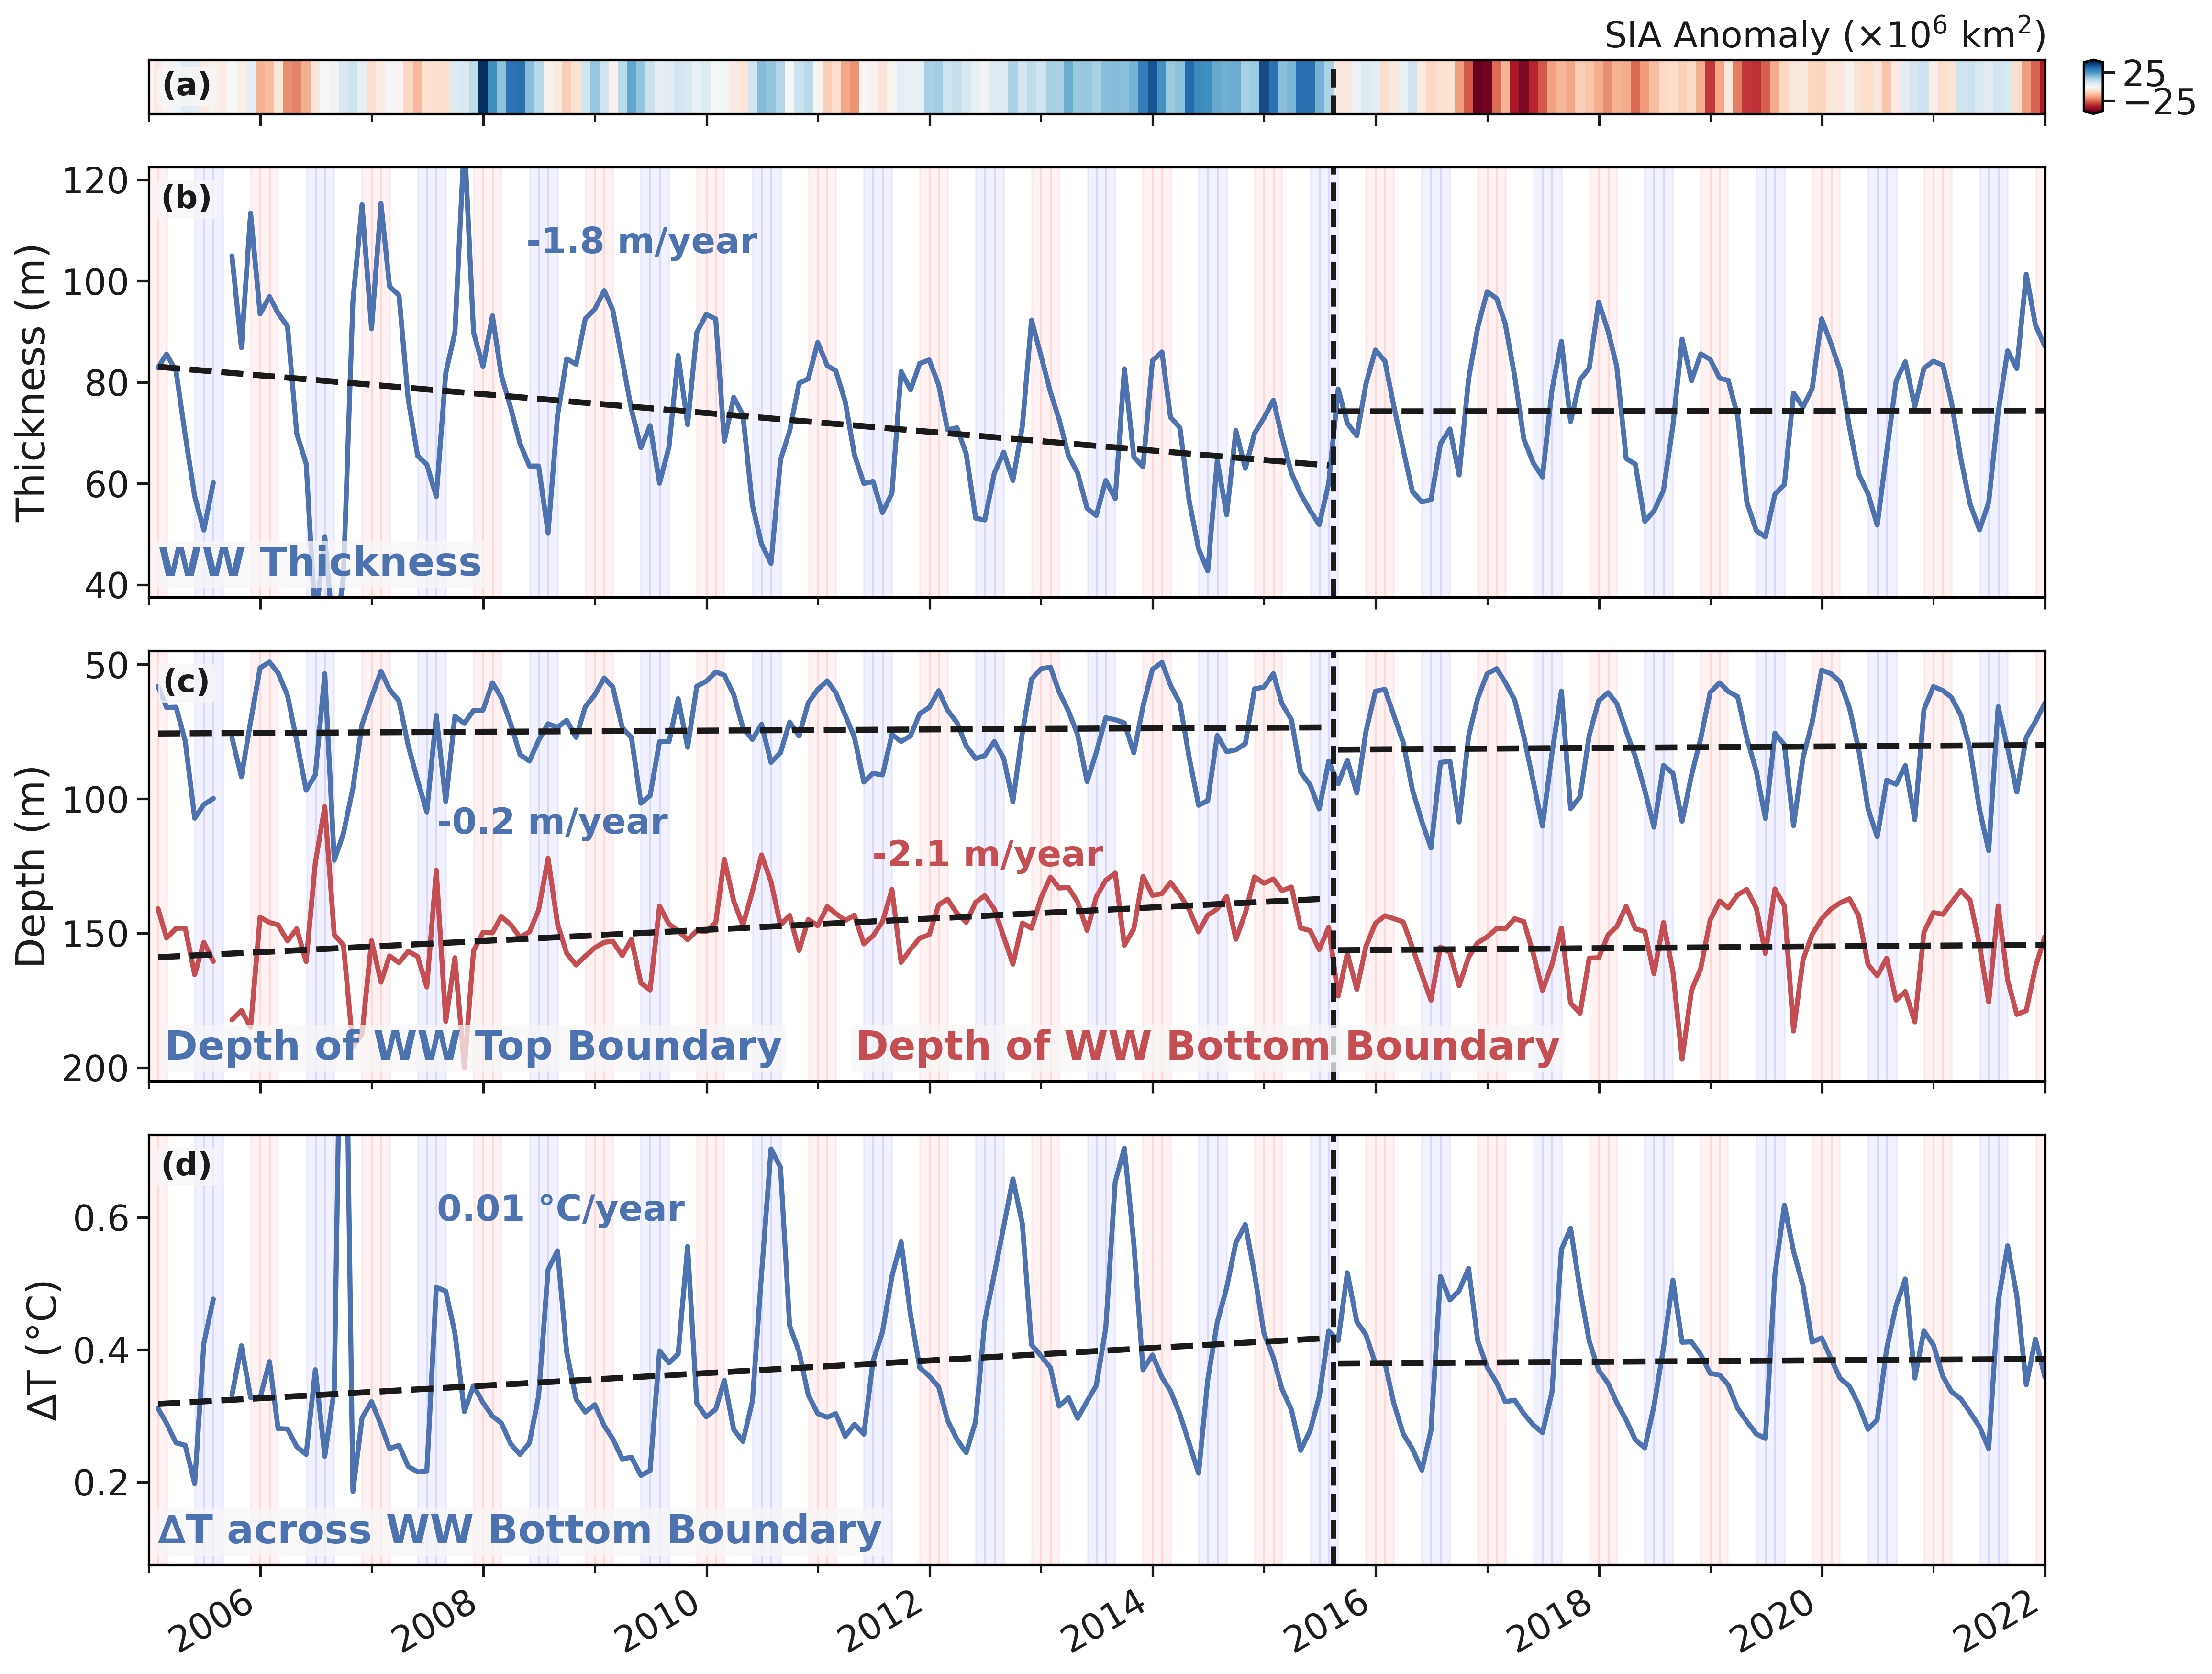

In [127]:
fig,ax = plt.subplots(4,2,figsize=(15*1.05,12),sharex='col',dpi=300, 
                      width_ratios=(5,0.05), height_ratios=(0.125,1,1,1))
ax = ax.flatten()
cax = ax[1::2]

# plot SIA climate stripes
plot_sea_ice_climate_stripes(si,ax[0],fig,cax=cax[0])

# plot WW thickness
line_kw = dict(x='time',lw=2.5,)
msk_ss['thcc'].mean(('lat','lon')).plot(**line_kw,ax=ax[2],c='b')
thcc1, thcc2 = plot_lin_reg(msk_ss['thcc'],ax[2],date=np.datetime64('2015-08-31'),return_slope_rate=1)

# plot upper and lower boundaries
msk_ss['up_bd'].mean(('lat','lon')).plot(**line_kw,ax=ax[4],c='b')
s_ub1, s_ub2 = plot_lin_reg(msk_ss['up_bd'],ax[4],date=np.datetime64('2015-08-31'),return_slope_rate=1)
msk_ss['lw_bd'].mean(('lat','lon')).plot(**line_kw,ax=ax[4],c='r')
s_lb1, s_lb2 = plot_lin_reg(msk_ss['lw_bd'],ax[4],date=np.datetime64('2015-08-31'),return_slope_rate=1)

deltaT.ctemp.mean(('lon','lat')).plot(**line_kw,ax=ax[6],c='b')
s_dt1, s_dt2 = plot_lin_reg(deltaT.ctemp,ax=ax[6],date=np.datetime64('2015-08-31'),return_slope_rate=1)

for a in ax[::2]:
    plot_with_season_background(msk_ss,a,alpha=0.05)
    si_timeseries_plot_formatting(ax=a,)

for i in [3, 5, 7,]:
    fig.delaxes(ax[i])

ax[2].set_ylim(37.5,122.5)
ax[4].set_ylim(45,205)
ax[6].set_ylim(0.1-0.025,0.725)
ax[6].set_yticks(np.arange(0.2,0.7,0.2))


ax[2].set_ylabel('Thickness (m)')
ax[4].set_ylabel('Depth (m)')
ax[4].invert_yaxis()
ax[6].set_ylabel('∆T (°C)')

# annotate figures
bbox_kw = dict(facecolor='#f7f7f7', edgecolor='None', boxstyle='round,pad=0.1',alpha=0.75,)
ann_kw = dict(fontsize=20,xycoords='axes fraction',weight=600,bbox=bbox_kw,)
ax[2].annotate(xy=(0.005,0.05),text=r'WW Thickness',c='b',**ann_kw)
ax[4].annotate(xy=(0.0085,0.05),text=r'Depth of WW Top Boundary',c='b',**ann_kw)
ax[4].annotate(xy=(0.005+6.25/17,0.05),text=r'Depth of WW Bottom Boundary',c='r',**ann_kw)
ax[6].annotate(xy=(0.005,0.05),text=r'∆T across WW Bottom Boundary',c='b',**ann_kw)

# add labels with slopes
ann_kw = dict(fontsize=18,xycoords='axes fraction',weight=600)
#ax[2].annotate(xy=(0.005+6/17-0.03,0.65),text=str(np.round(thcc1*12,1))+' m/year',c='b',**ann_kw)
ax[2].annotate(xy=(0.005+3.3/17,0.8),text=str(np.round(thcc1*12,1))+' m/year',c='b',**ann_kw)
ax[4].annotate(xy=(0.005+2.5/17,0.575),text=str(np.round(s_ub1*12,1))+' m/year',c='b',**ann_kw)
#ax[4].annotate(xy=(0.005+4.75/17,0.60),text=str(np.round(s_ub1*12,1))+' dbar/year',c='b',**ann_kw)
ax[4].annotate(xy=(0.005+6.4/17,0.5),text=str(np.round(s_lb1*12,1))+' m/year',c='r',**ann_kw)
ax[6].annotate(xy=(0.005+2.5/17,0.8),text=str(np.round(s_dt1*12,2)
                )+' °C/year',c='b',**ann_kw)

fig_labels(0.02,.5,ax=ax[0],fs=16)
fig_labels(0.02,.925,ax=ax[2::2],j=1,fs=16)

#for a in ax[1:]:
#    a.grid('y',c='darkgrey')
#ax[2].set_yticks(np.arange(40,121,5))
#ax[4].set_yticks(np.arange(50,200,10))

fig.tight_layout()

# check for all WW data

In [10]:
importlib.reload(sys.modules['gridding'])

<module 'gridding' from '/home/theospira/notebooks/projects/03-WW-timeseries/funcs/gridding.py'>

In [6]:
from gridding import vincents_median_grid_var,median_gridding_ts

In [7]:
d_path='/home/theospira/notebooks/projects/03-WW-timeseries/data/hydrographic_profiles/'
ds = xr.open_dataset(d_path+'hydrographic_profiles_1.nc')

In [9]:
tmp = ds.isel(n_prof=np.where((ds.ww_type.notnull()))[0])

# grid WW_SS data
arr = []
for v in tqdm(['up_bd_z','lw_bd_z','thcc_z']):
    arr += median_gridding_ts(tmp[v]),

x    = 1 
time = pd.date_range('2004-01-01', '2022-01-01', freq='1M')
lat  = np.arange(-79.5,-40.5+x,x)
lon  = np.arange(-180,180,x) + x/2

ww = xr.Dataset(
            data_vars = dict(up_bd = (['time','lon','lat',], arr[0].data),
                             lw_bd = (['time','lon','lat',], arr[1].data),
                             thcc  = (['time','lon','lat',], arr[2].data),
                            ),
            coords   = dict(time    = (['time'], time),
                            lon     = (['lon'], lon),
                            lat     = (['lat'], lat),
                            ),)

for v in ['up_bd', 'lw_bd', 'thcc']:
    ww[v].attrs['units'] = 'm'

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/216 [00:00<?, ?it/s]

  0%|          | 0/216 [00:00<?, ?it/s]

  0%|          | 0/216 [00:00<?, ?it/s]

In [36]:
ww['ww_ct'] = xr.DataArray(xr.open_dataset(d_path+'gridded-timeseries-ww-recalc1.nc')['ww_ct'].data,
                           dims=['time','lon','lat'])

for v in ['up_bd', 'lw_bd', 'thcc']:
    ww = calc_mean_var(ww,v)
    ww[v+'_anm'] = ww[v] - ww[v+'_mn']

ww_msk = mask_data(ww)

contains ww_ct


In [37]:
msk_ss = ww_msk.copy()

In [65]:
# compute the vertical temperature gradient between WW and ocean interior
mp = 300 - (300 - tmp.lw_bd)/2 # find midpoint of ocean interior
T_diff = tmp.ctemp.sel(pres=mp,method='nearest') - tmp.ww_ct

# grid variable
arr = median_gridding_ts(T_diff)

x    = 1 
time = pd.date_range('2004-01-01', '2022-01-01', freq='1M')
lat  = np.arange(-79.5,-40.5+x,x)
lon  = np.arange(-180,180,x) + x/2

deltaT = xr.Dataset(
            data_vars = dict(ctemp = (['time','lon','lat',], arr),
                            ),
            coords   = dict(time   = (['time'], time),
                            lon    = (['lon'], lon),
                            lat    = (['lat'], lat),
                            ),)

# mask data
deltaT['ww_ct'] = xr.DataArray(xr.open_dataset(d_path+'gridded-timeseries-ww-recalc1.nc')['ww_ct'].data,
                               dims=['time','lon','lat'])
deltaT = mask_data(deltaT)

  0%|          | 0/216 [00:00<?, ?it/s]

contains ww_ct


In [66]:
# load sea ice
si = load_sea_ice()
si = si.sel(lat=slice(-80,-52)).sel(time=slice('2005-01-01','2022-01-01'))
# mask sea ice data
#si['ww_ct'] = tmp['ww_ct'].copy()
#si = mask_data(si)
si = calc_mean_var(si,'sia')
si = calc_mean_var(si,'sic')

# compute sia_anm
si['sia_anm'] = si.sia - si.sia_mn

cmap_br = get_cmap()

slope 1:  -0.1414986583628224  per unit time
slope 2:  -0.02846214308093378  per unit time
slope 1:  -0.09315250631134775  per unit time
slope 2:  -0.023057001361010798  per unit time
slope 1:  -0.2328709143761648  per unit time
slope 2:  -0.05739834300907567  per unit time
slope 1:  0.003027806080759579  per unit time
slope 2:  0.000113727721086079  per unit time


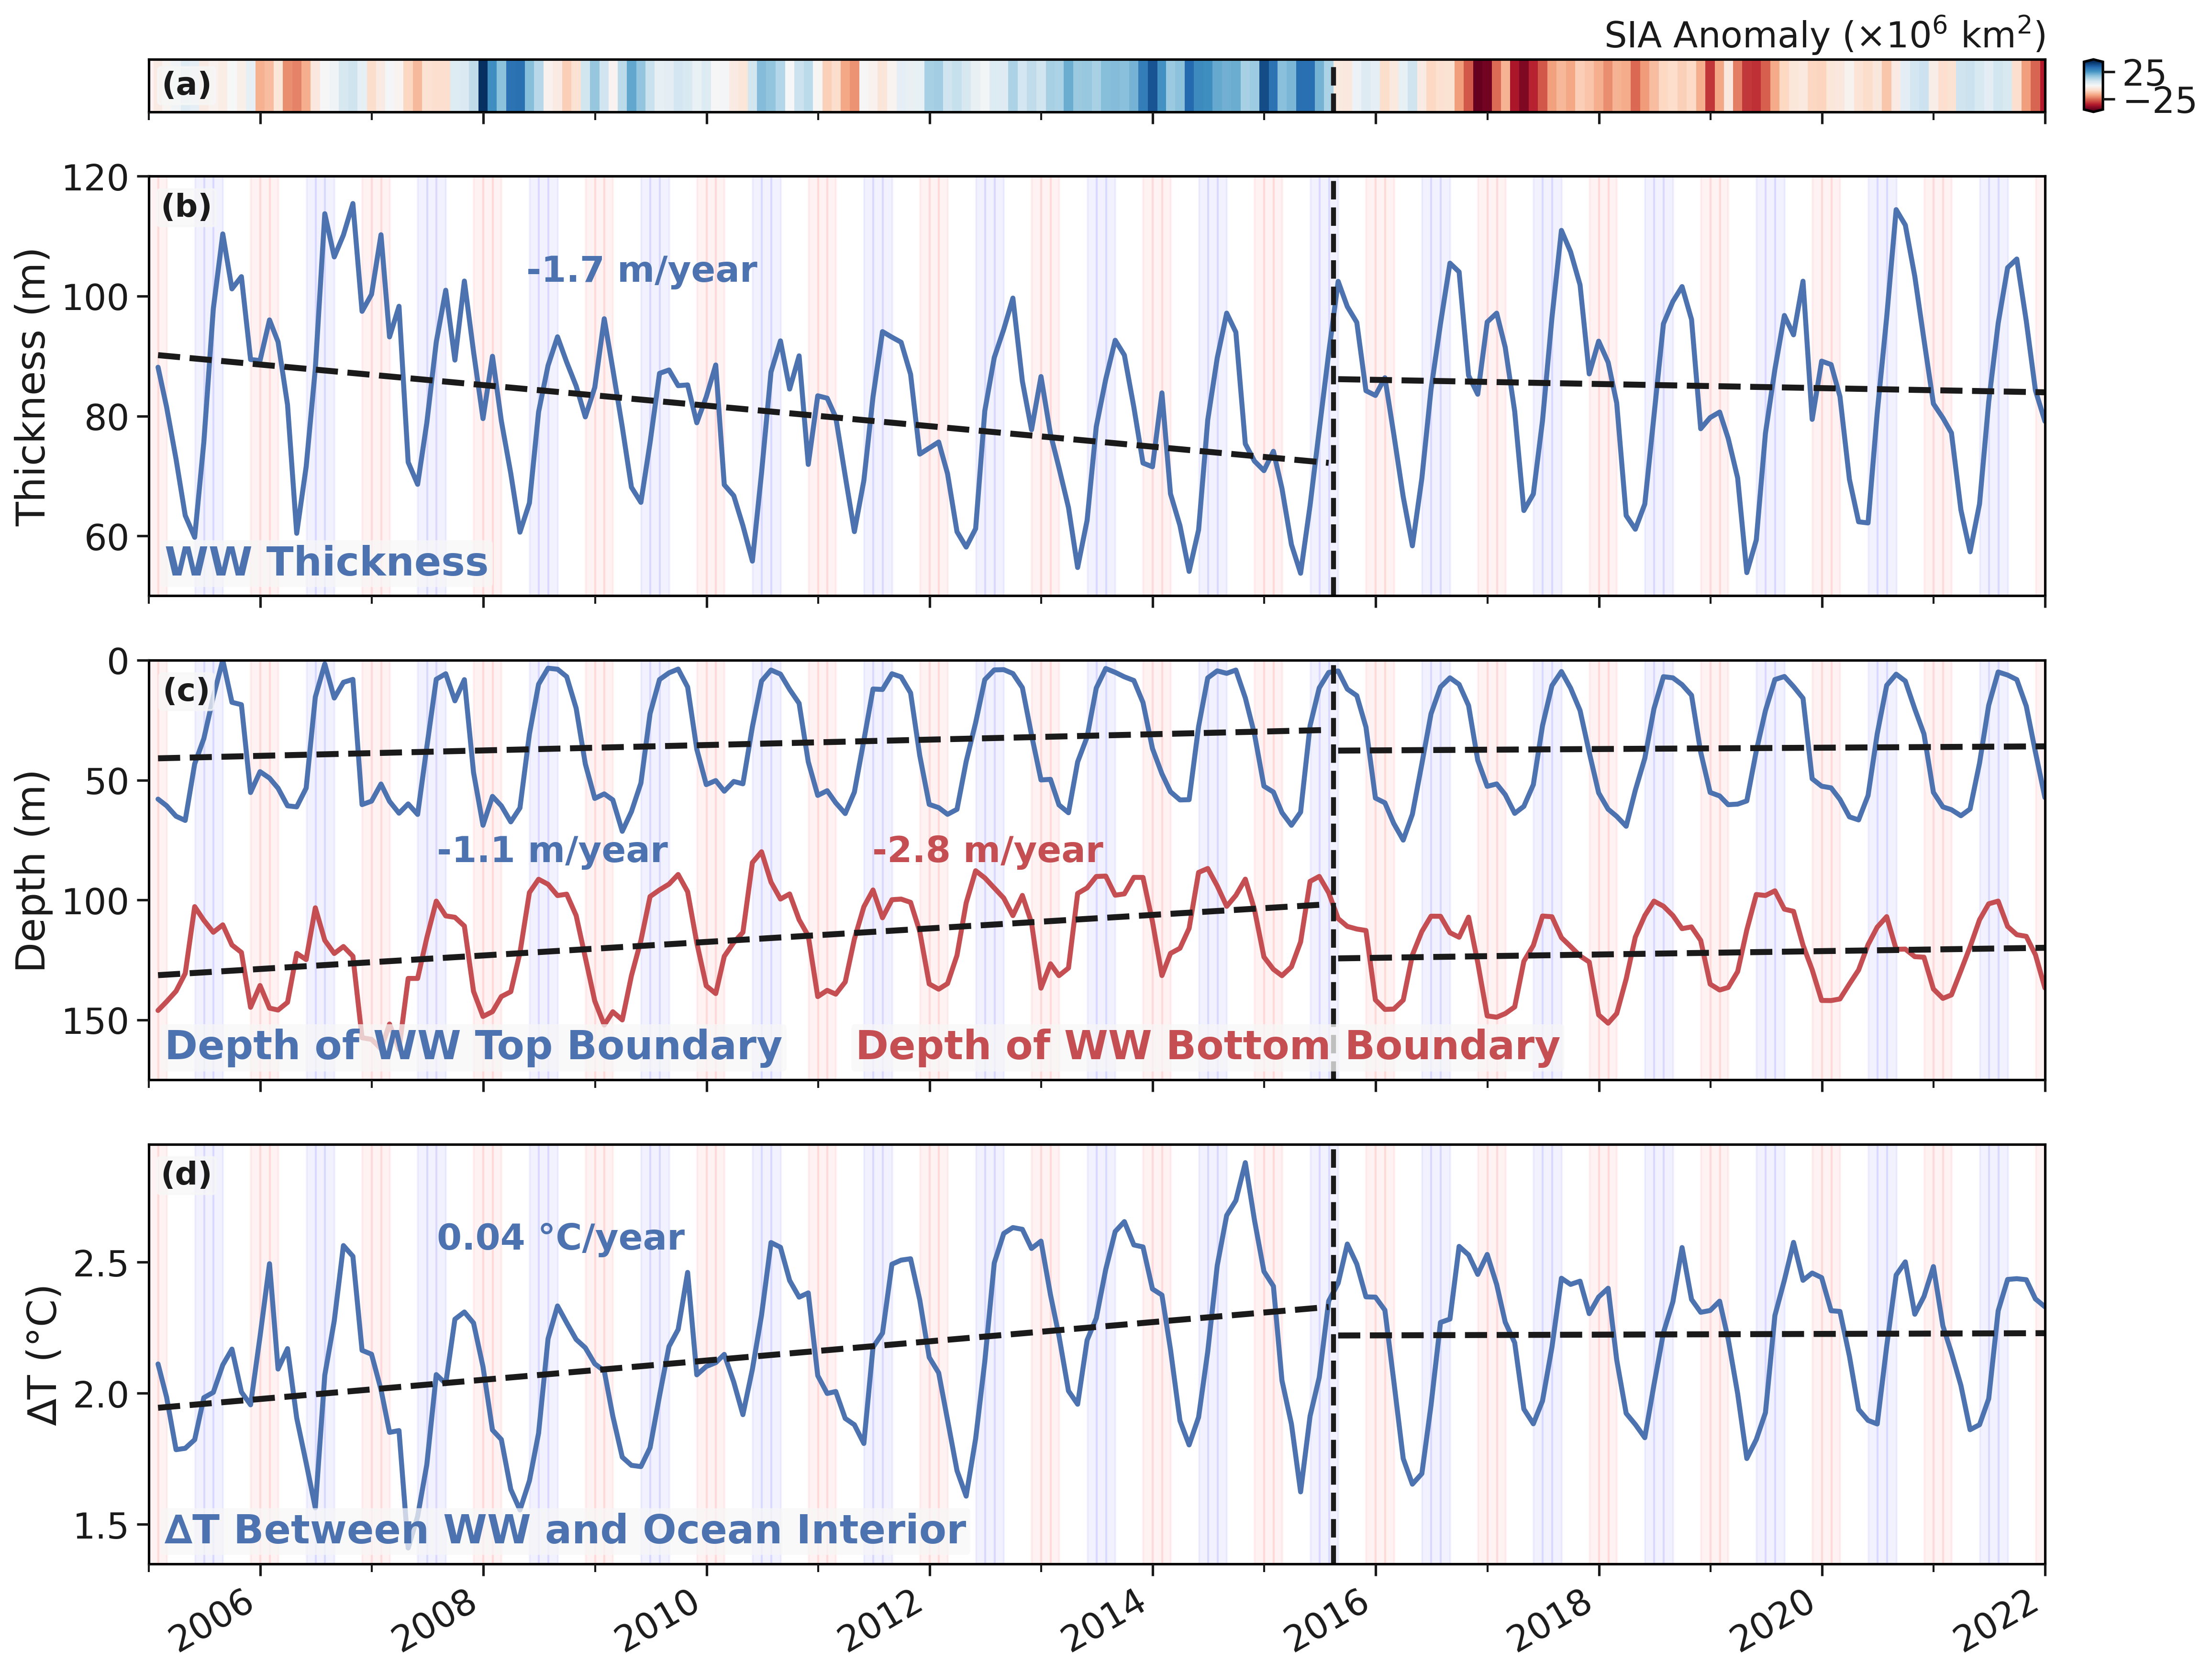

In [67]:
fig,ax = plt.subplots(4,2,figsize=(15*1.05,12),sharex='col',dpi=300, 
                      width_ratios=(5,0.05), height_ratios=(0.125,1,1,1))
ax = ax.flatten()
cax = ax[1::2]

# plot SIA climate stripes
plot_sea_ice_climate_stripes(si,ax[0],fig,cax=cax[0])

# plot WW thickness
line_kw = dict(x='time',lw=2.5,)
msk_ss['thcc'].mean(('lat','lon')).plot(**line_kw,ax=ax[2],c='b')
thcc1, thcc2 = plot_lin_reg(msk_ss['thcc'],ax[2],date=np.datetime64('2015-08-31'),return_slope_rate=1)

# plot upper and lower boundaries
msk_ss['up_bd'].mean(('lat','lon')).plot(**line_kw,ax=ax[4],c='b')
s_ub1, s_ub2 = plot_lin_reg(msk_ss['up_bd'],ax[4],date=np.datetime64('2015-08-31'),return_slope_rate=1)
msk_ss['lw_bd'].mean(('lat','lon')).plot(**line_kw,ax=ax[4],c='r')
s_lb1, s_lb2 = plot_lin_reg(msk_ss['lw_bd'],ax[4],date=np.datetime64('2015-08-31'),return_slope_rate=1)

deltaT.ctemp.mean(('lon','lat')).plot(**line_kw,ax=ax[6],c='b')
s_dt1, s_dt2 = plot_lin_reg(deltaT.ctemp,ax=ax[6],date=np.datetime64('2015-08-31'),return_slope_rate=1)

for a in ax[::2]:
    plot_with_season_background(msk_ss,a,alpha=0.05)
    si_timeseries_plot_formatting(ax=a,)

for i in [3, 5, 7,]:
    fig.delaxes(ax[i])

ax[2].set_ylim(50,120)
ax[4].set_ylim(0,175)
ax[6].set_ylim(1.35,2.95)
#ax[6].set_yticks(np.arange(0.2,0.7,0.2))


ax[2].set_ylabel('Thickness (m)')
ax[4].set_ylabel('Depth (m)')
ax[4].invert_yaxis()
ax[6].set_ylabel('∆T (°C)')

# annotate figures
bbox_kw = dict(facecolor='#f7f7f7', edgecolor='None', boxstyle='round,pad=0.1',alpha=0.75,)
ann_kw = dict(fontsize=20,xycoords='axes fraction',weight=600,bbox=bbox_kw,)
ax[2].annotate(xy=(0.0085,0.05),text=r'WW Thickness',c='b',**ann_kw)
ax[4].annotate(xy=(0.0085,0.05),text=r'Depth of WW Top Boundary',c='b',**ann_kw)
ax[4].annotate(xy=(0.005+6.25/17,0.05),text=r'Depth of WW Bottom Boundary',c='r',**ann_kw)
ax[6].annotate(xy=(0.0085,0.05),text=r'∆T Between WW and Ocean Interior',c='b',**ann_kw)

# add labels with slopes
ann_kw = dict(fontsize=18,xycoords='axes fraction',weight=600)
#ax[2].annotate(xy=(0.005+6/17-0.03,0.65),text=str(np.round(thcc1*12,1))+' m/year',c='b',**ann_kw)
ax[2].annotate(xy=(0.005+3.3/17,0.75),text=str(np.round(thcc1*12,1))+' m/year',c='b',**ann_kw)
ax[4].annotate(xy=(0.005+2.5/17,0.52),text=str(np.round(s_ub1*12,1))+' m/year',c='b',**ann_kw)
#ax[4].annotate(xy=(0.005+4.75/17,0.60),text=str(np.round(s_ub1*12,1))+' dbar/year',c='b',**ann_kw)
ax[4].annotate(xy=(0.005+6.4/17,0.52),text=str(np.round(s_lb1*12,1))+' m/year',c='r',**ann_kw)
ax[6].annotate(xy=(0.005+2.5/17,0.75),text=str(np.round(s_dt1*12,2))+' °C/year',c='b',**ann_kw)

fig_labels(0.02,.5,ax=ax[0],fs=16)
fig_labels(0.02,.925,ax=ax[2::2],j=1,fs=16)

#for a in ax[1:]:
#    a.grid('y',c='darkgrey')
#ax[2].set_yticks(np.arange(40,121,5))
#ax[4].set_yticks(np.arange(50,200,10))

fig.tight_layout()

In [76]:
msk_ss['thcc'].mean(('lat','lon')).groupby('time.season')['DJF'].mean().round(0)

<xarray.DataArray 'thcc' ()>
array(83.)

In [111]:
s1, i1, s2, i2 = plot_lin_reg(msk_ss['lw_bd'],ax[2],date=np.datetime64('2015-08-31'),return_coeffs=1,)

slope 1:  -0.2328709143761648  per unit time
slope 2:  -0.05739834300907567  per unit time


In [124]:
import matplotlib.dates as mdates

In [163]:
deltaT.ctemp.mean(('lat','lon'))[:127].mean().round(2)

<xarray.DataArray 'ctemp' ()>
array(2.14)

In [166]:
chk = []
for yr in deltaT.ctemp.mean(('lat','lon'))[:127].groupby('time.year'):
    chk += yr[1].min().data,

chk = np.asarray(chk)
chk

array([1.78511323, 1.56286317, 1.41035   , 1.5551004 , 1.72059654,
       1.91862262, 1.80870721, 1.60790834, 1.95831912, 1.80325116,
       1.62425925])

In [172]:
2005+chk.argmax(),chk.argmin()+2005

(2013, 2007)

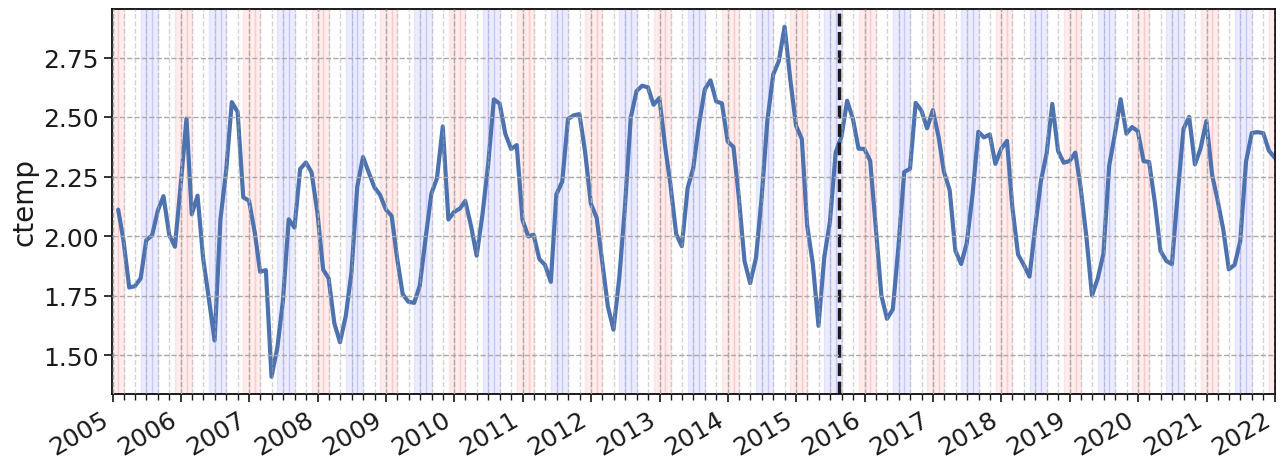

In [134]:
deltaT.ctemp.mean(('lat','lon')).plot(x='time',figsize=(15,5),lw=3)
si_timeseries_plot_formatting(plt.gca())
plot_with_season_background(deltaT)
plt.gca().xaxis.set_minor_locator(mdates.MonthLocator(range(1,13,2)))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())

plt.grid(ls='--',c='darkgrey')
plt.grid(which='minor',axis='x',ls='--',c='darkgrey',alpha=0.5)

In [109]:
np.round(100*(1 - y[-1]/y[0]))

20.0

## try with fixed depth

In [65]:
# compute the vertical temperature gradient between WW and ocean interior
mp = 200  # find midpoint of ocean interior
T_diff = tmp.ctemp.sel(pres=mp,method='nearest') - tmp.ww_ct

# grid variable
arr = median_gridding_ts(T_diff)

x    = 1 
time = pd.date_range('2004-01-01', '2022-01-01', freq='1M')
lat  = np.arange(-79.5,-40.5+x,x)
lon  = np.arange(-180,180,x) + x/2

deltaT = xr.Dataset(
            data_vars = dict(ctemp = (['time','lon','lat',], arr),
                            ),
            coords   = dict(time   = (['time'], time),
                            lon    = (['lon'], lon),
                            lat    = (['lat'], lat),
                            ),)

# mask data
deltaT['ww_ct'] = xr.DataArray(xr.open_dataset(d_path+'gridded-timeseries-ww-recalc1.nc')['ww_ct'].data,
                               dims=['time','lon','lat'])
deltaT = mask_data(deltaT)

  0%|          | 0/216 [00:00<?, ?it/s]

contains ww_ct


slope 1:  -0.1414986583628224  per unit time
slope 2:  -0.02846214308093378  per unit time
slope 1:  -0.09315250631134775  per unit time
slope 2:  -0.023057001361010798  per unit time
slope 1:  -0.2328709143761648  per unit time
slope 2:  -0.05739834300907567  per unit time
slope 1:  0.004333310101475361  per unit time
slope 2:  0.0005131490200372453  per unit time


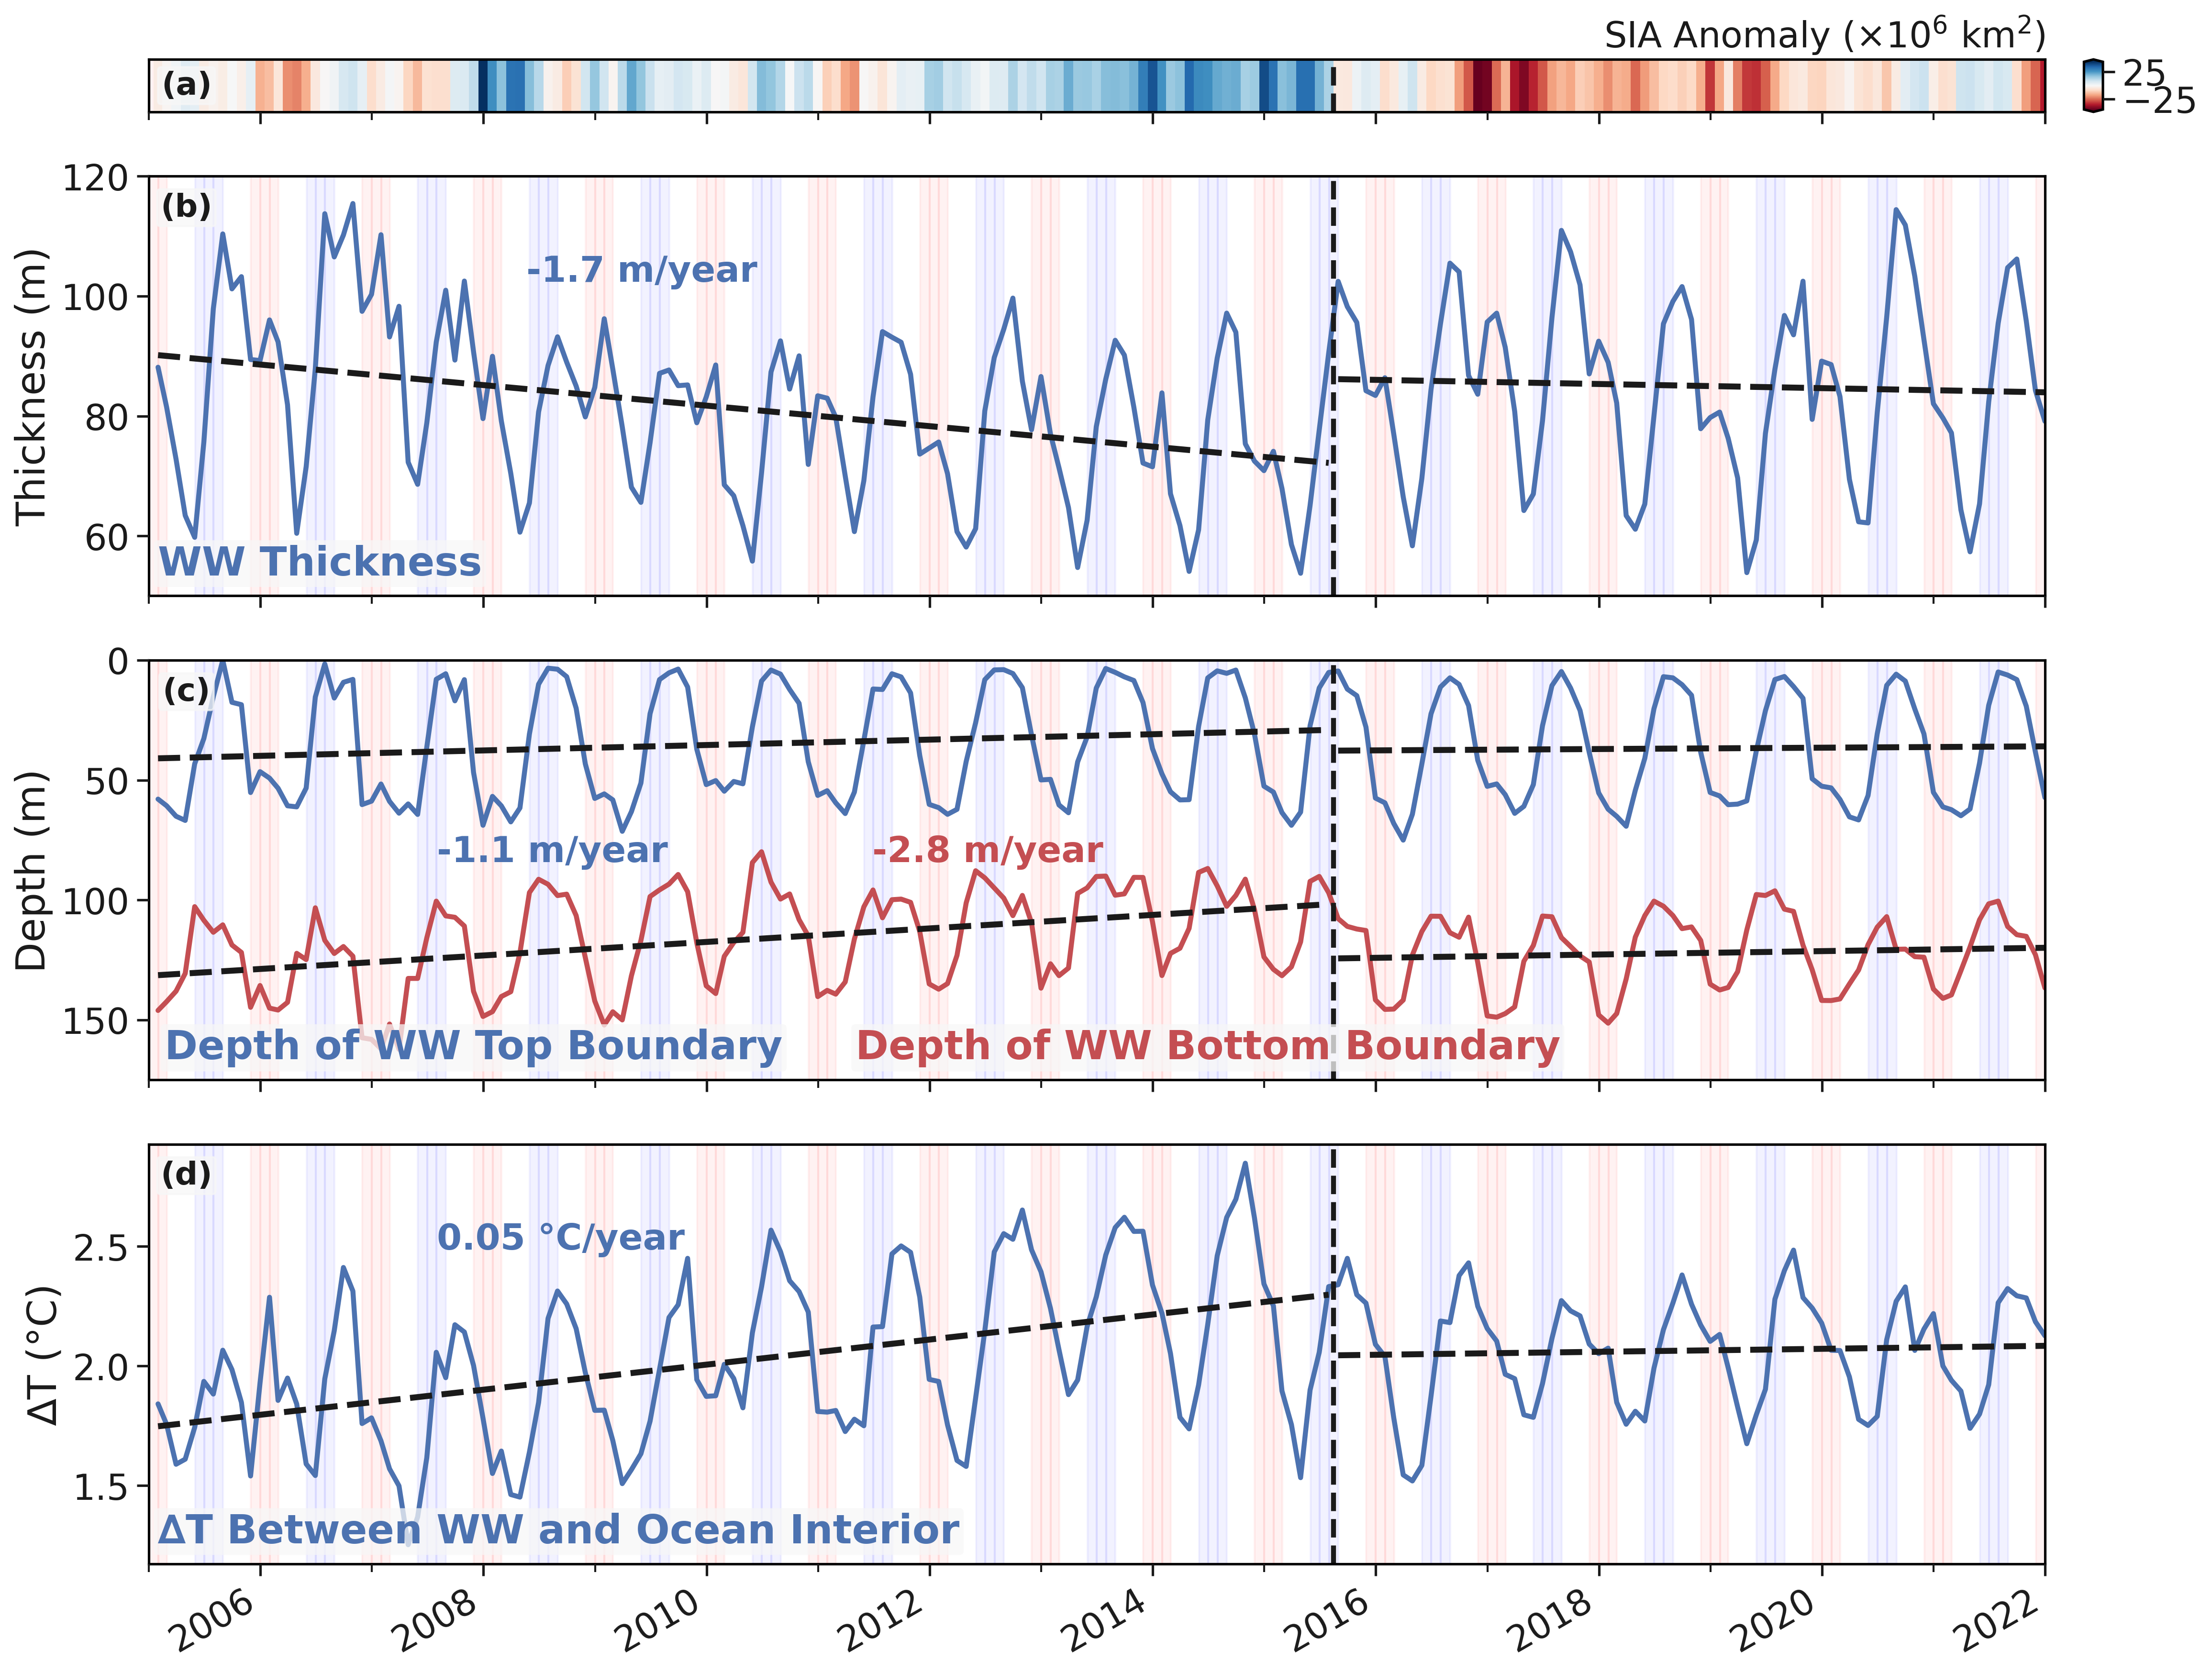

In [61]:
fig,ax = plt.subplots(4,2,figsize=(15*1.05,12),sharex='col',dpi=300, 
                      width_ratios=(5,0.05), height_ratios=(0.125,1,1,1))
ax = ax.flatten()
cax = ax[1::2]

# plot SIA climate stripes
plot_sea_ice_climate_stripes(si,ax[0],fig,cax=cax[0])

# plot WW thickness
line_kw = dict(x='time',lw=2.5,)
msk_ss['thcc'].mean(('lat','lon')).plot(**line_kw,ax=ax[2],c='b')
thcc1, thcc2 = plot_lin_reg(msk_ss['thcc'],ax[2],date=np.datetime64('2015-08-31'),return_slope_rate=1)

# plot upper and lower boundaries
msk_ss['up_bd'].mean(('lat','lon')).plot(**line_kw,ax=ax[4],c='b')
s_ub1, s_ub2 = plot_lin_reg(msk_ss['up_bd'],ax[4],date=np.datetime64('2015-08-31'),return_slope_rate=1)
msk_ss['lw_bd'].mean(('lat','lon')).plot(**line_kw,ax=ax[4],c='r')
s_lb1, s_lb2 = plot_lin_reg(msk_ss['lw_bd'],ax[4],date=np.datetime64('2015-08-31'),return_slope_rate=1)

deltaT.ctemp.mean(('lon','lat')).plot(**line_kw,ax=ax[6],c='b')
s_dt1, s_dt2 = plot_lin_reg(deltaT.ctemp,ax=ax[6],date=np.datetime64('2015-08-31'),return_slope_rate=1)

for a in ax[::2]:
    plot_with_season_background(msk_ss,a,alpha=0.05)
    si_timeseries_plot_formatting(ax=a,)

for i in [3, 5, 7,]:
    fig.delaxes(ax[i])

ax[2].set_ylim(50,120)
ax[4].set_ylim(0,175)
#ax[6].set_ylim(1.35,2.95)
#ax[6].set_yticks(np.arange(0.2,0.7,0.2))


ax[2].set_ylabel('Thickness (m)')
ax[4].set_ylabel('Depth (m)')
ax[4].invert_yaxis()
ax[6].set_ylabel('∆T (°C)')

# annotate figures
bbox_kw = dict(facecolor='#f7f7f7', edgecolor='None', boxstyle='round,pad=0.1',alpha=0.75,)
ann_kw = dict(fontsize=20,xycoords='axes fraction',weight=600,bbox=bbox_kw,)
ax[2].annotate(xy=(0.005,0.05),text=r'WW Thickness',c='b',**ann_kw)
ax[4].annotate(xy=(0.0085,0.05),text=r'Depth of WW Top Boundary',c='b',**ann_kw)
ax[4].annotate(xy=(0.005+6.25/17,0.05),text=r'Depth of WW Bottom Boundary',c='r',**ann_kw)
ax[6].annotate(xy=(0.005,0.05),text=r'∆T Between WW and Ocean Interior',c='b',**ann_kw)

# add labels with slopes
ann_kw = dict(fontsize=18,xycoords='axes fraction',weight=600)
#ax[2].annotate(xy=(0.005+6/17-0.03,0.65),text=str(np.round(thcc1*12,1))+' m/year',c='b',**ann_kw)
ax[2].annotate(xy=(0.005+3.3/17,0.75),text=str(np.round(thcc1*12,1))+' m/year',c='b',**ann_kw)
ax[4].annotate(xy=(0.005+2.5/17,0.52),text=str(np.round(s_ub1*12,1))+' m/year',c='b',**ann_kw)
#ax[4].annotate(xy=(0.005+4.75/17,0.60),text=str(np.round(s_ub1*12,1))+' dbar/year',c='b',**ann_kw)
ax[4].annotate(xy=(0.005+6.4/17,0.52),text=str(np.round(s_lb1*12,1))+' m/year',c='r',**ann_kw)
ax[6].annotate(xy=(0.005+2.5/17,0.75),text=str(np.round(s_dt1*12,2))+' °C/year',c='b',**ann_kw)

fig_labels(0.02,.5,ax=ax[0],fs=16)
fig_labels(0.02,.925,ax=ax[2::2],j=1,fs=16)

#for a in ax[1:]:
#    a.grid('y',c='darkgrey')
#ax[2].set_yticks(np.arange(40,121,5))
#ax[4].set_yticks(np.arange(50,200,10))

fig.tight_layout()

In [63]:
msk_ss.lw_bd.mean(('lat','lon')).max()

<xarray.DataArray 'lw_bd' ()>
array(162.27803481)